### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_auc_score
from nltk.tokenize import RegexpTokenizer

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.ensemble import RandomForestClassifier





%matplotlib inline

pd.set_option("display.precision", 20)

np.set_printoptions(suppress=True)

### Loading Data

In [2]:
control_df = pd.read_csv('tweets_2016')

In [3]:
l = ['tweet_text', 'tweet_id']

control_df =  control_df[l]

In [4]:
control_df['target'] = 0

In [5]:
control_df= control_df[control_df.tweet_text != 'None']

In [6]:
control_df

,tweet_text,tweet_id,target
0,RT @ReaganBattalion: Obama hates @marcorubio b...,789285389651570688.0,0
2,RT @lopezdoriga: EN DIRECTO en #Periscope: La ...,789329855565275136.0,0
3,RT @wikileaks: There is no US election. There ...,789324603516657664.0,0
7,RT @AJemaineClement: The lamest part of Trump'...,789269561203752960.0,0
14,@realDonaldTrump #AlSmithDinner #TrumpTapes #H...,789351683503562752.0,0
...,...,...,...
73211,RT @LifeSite: The next ‘deplorables’? Clinton ...,789267711725412352.0,0
73212,Speaking is not his thing. He isn't intellectu...,789267976000118784.0,0
73220,#Bestseller #greatreads #goodbooks #BookBoost...,789377697524748288.0,0
73226,RT @activist360: The #AlSmithDinner was no dif...,789331213731434496.0,0


In [7]:
targetdf =  pd.read_csv('hydrated_tweets')

In [8]:
targetdf = targetdf[l]

In [9]:
targetdf['target'] = 1

In [10]:
targetdf= targetdf[targetdf.tweet_text != 'None']

In [11]:
targetdf

,tweet_text,tweet_id,target
0,I'm not saying I believe there was widespread ...,1329817517590786054,1
1,Yes of course! https://t.co/YqpjvH0NoS,1330873630515896321,1
2,@RepPaulMitchell @realDonaldTrump Are you real...,1333262884357419010,1
3,Unity! https://t.co/I625kseVMn,1331653544579981314,1
4,Listen to this https://t.co/uhKFLA3GVz,1329835459200114688,1
...,...,...,...
67506,@ACTBrigitte Count my family and friends. This...,1331497791944843266,1
67508,@JudiciaryGOP @GOPChairwoman @GOP @GOPLeader @...,1327465594090754048,1
67510,OMG https://t.co/QFx2mxyRmj,1331580447495696385,1
67513,#election2020 #election2020results #electionre...,1325128552426057734,1


In [12]:
alldf = control_df.append(targetdf)

In [13]:
alldf.dropna(inplace=True)

In [14]:
alldf.set_index('tweet_id' , inplace=True)

In [15]:
alldf

,tweet_text,target
tweet_id,,
789285389651570688.0,RT @ReaganBattalion: Obama hates @marcorubio b...,0
789329855565275136.0,RT @lopezdoriga: EN DIRECTO en #Periscope: La ...,0
789324603516657664.0,RT @wikileaks: There is no US election. There ...,0
789269561203752960.0,RT @AJemaineClement: The lamest part of Trump'...,0
789351683503562752.0,@realDonaldTrump #AlSmithDinner #TrumpTapes #H...,0
...,...,...
1331497791944843264.0,@ACTBrigitte Count my family and friends. This...,1
1327465594090754048.0,@JudiciaryGOP @GOPChairwoman @GOP @GOPLeader @...,1
1331580447495696384.0,OMG https://t.co/QFx2mxyRmj,1


### Train Test Split 

In [16]:
X= alldf.tweet_text
y = alldf.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [17]:
nltk_sw = stopwords.words('english')
politcal_stop = ['trump']
tweetstop = ['https', 'co', 'rt']
for i in tweetstop:
    nltk_sw.append(i)

In [18]:
cv_dict = {}
def reportcrossval(model, model_name, X, Y):
    cv_mean = cross_val_score(model, X, Y).mean()
    cv_dict[model_name] = cv_mean
    print(f"The cv mean of {model_name} is {cv_mean}")

In [19]:
pipe_dummy = Pipeline([('dummy', DummyClassifier(strategy='most_frequent'))], verbose=True)

In [20]:
pipe_cv_mnnb = Pipeline(steps=[('cv', CountVectorizer()),
                               ('mnnb', MultinomialNB())],
                        verbose=True)

In [21]:
reportcrossval(pipe_dummy, 'Dummy', X_train, y_train)

[Pipeline] ............. (step 1 of 1) Processing dummy, total=   0.0s
[Pipeline] ............. (step 1 of 1) Processing dummy, total=   0.0s
[Pipeline] ............. (step 1 of 1) Processing dummy, total=   0.0s
[Pipeline] ............. (step 1 of 1) Processing dummy, total=   0.0s
[Pipeline] ............. (step 1 of 1) Processing dummy, total=   0.0s
The cv mean of Dummy is 0.5620654509624294


In [22]:
reportcrossval(pipe_cv_mnnb, 'Default CV and MNNB', X_train, y_train)

[Pipeline] ................ (step 1 of 2) Processing cv, total=   1.1s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing cv, total=   1.1s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing cv, total=   1.1s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing cv, total=   1.1s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing cv, total=   1.1s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s
The cv mean of Default CV and MNNB is 0.9840377061709423


In [23]:
pipe_cv_mnnb.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 2) Processing cv, total=   1.3s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s


Pipeline(steps=[('cv', CountVectorizer()), ('mnnb', MultinomialNB())],
         verbose=True)

#### Iteration one:

We're once again trying the gridsearch for the new stopwords.

In [24]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

basiclemmer = LemmaTokenizer()

In [25]:
param_grid1 = {'cv__ngram_range': [(1, 1), (1, 2), (1, 3)],
               'cv__stop_words': [None, nltk_sw, politcal_stop],
               'cv__tokenizer' : [None, basiclemmer]}

In [26]:
grid1 = GridSearchCV(pipe_cv_mnnb, param_grid1, verbose=1, n_jobs = 4)

In [27]:
grid1.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   13.3s
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:   36.5s finished


[Pipeline] ................ (step 1 of 2) Processing cv, total=   4.5s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s


GridSearchCV(estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('mnnb', MultinomialNB())],
                                verbose=True),
             n_jobs=4,
             param_grid={'cv__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'cv__stop_words': [None,
                                            ['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                            ['trump']],
 

In [28]:
display(grid1.best_estimator_)
display(grid1.best_score_)
display(grid1.best_params_)

Pipeline(steps=[('cv', CountVectorizer(ngram_range=(1, 3))),
                ('mnnb', MultinomialNB())],
         verbose=True)

0.9876233267387254

{'cv__ngram_range': (1, 3), 'cv__stop_words': None, 'cv__tokenizer': None}

In [29]:
bestfromgrid1 = Pipeline(steps=[('cv', CountVectorizer(ngram_range =(1, 3))),
                               ('mnnb', MultinomialNB())],
                        verbose=True)

In [30]:
bestfromgrid1.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 2) Processing cv, total=   4.5s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s


Pipeline(steps=[('cv', CountVectorizer(ngram_range=(1, 3))),
                ('mnnb', MultinomialNB())],
         verbose=True)

In [31]:
 reportcrossval(bestfromgrid1, 'Best CountVectorizer', X_train, y_train)

[Pipeline] ................ (step 1 of 2) Processing cv, total=   3.6s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing cv, total=   3.6s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing cv, total=   3.6s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing cv, total=   3.6s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing cv, total=   3.7s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s
The cv mean of Best CountVectorizer is 0.9876233267387254


The best model here is unchanged, even given the tweak to the stop words.

#### Random Forest

We know that the new stopwords had an effect on our random forest classifier from before. Let's check the other parameters.  

In [32]:
pipe_cv_rf = Pipeline(steps=[('cv', CountVectorizer()), 
                            ('rf', RandomForestClassifier(random_state=42))],
                            verbose=True)

In [86]:
param_grid2 = {'cv__ngram_range': [(1, 1), (1, 2)],
               'cv__tokenizer' : [None, basiclemmer],
               'cv__stop_words': [None, nltk_sw],
               'rf__n_estimators': [100,200,500]
               }

In [87]:
grid2 = GridSearchCV(pipe_cv_rf, param_grid2, verbose=1, n_jobs = 5)

In [88]:
grid2.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  3.3min
[Parallel(n_jobs=5)]: Done 120 out of 120 | elapsed: 13.3min finished


[Pipeline] ................ (step 1 of 2) Processing cv, total=   1.4s
[Pipeline] ................ (step 2 of 2) Processing rf, total= 1.5min


GridSearchCV(estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))],
                                verbose=True),
             n_jobs=5,
             param_grid={'cv__ngram_range': [(1, 1), (1, 2)],
                         'cv__stop_words': [None,
                                            ['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...]],
  

In [89]:
display(grid2.best_estimator_)
display(grid2.best_score_)
display(grid2.best_params_)

Pipeline(steps=[('cv',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('rf',
                 RandomForestClassifier(n_estimators=500, random_state=42))],
         verbose=True)

0.9935932689482015

{'cv__ngram_range': (1, 1),
 'cv__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',
  'to',
  'from',
  'up',
  'down',
  'in',
  'out',
  'on',
  'off',
  'o

In [37]:
bestofgrid2 = Pipeline(steps=[('cv', CountVectorizer(stop_words = nltk_sw)), 
                            ('rf', RandomForestClassifier(n_estimators = 500, random_state=42))],
                            verbose=True)
bestofgrid2.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 2) Processing cv, total=   1.3s
[Pipeline] ................ (step 2 of 2) Processing rf, total= 1.4min


Pipeline(steps=[('cv',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('rf',
                 RandomForestClassifier(n_estimators=500, random_state=42))],
         verbose=True)

In [38]:
 reportcrossval(bestofgrid2, 'Best RandomForestClassifier', X_train, y_train)

[Pipeline] ................ (step 1 of 2) Processing cv, total=   1.0s
[Pipeline] ................ (step 2 of 2) Processing rf, total= 1.1min
[Pipeline] ................ (step 1 of 2) Processing cv, total=   1.0s
[Pipeline] ................ (step 2 of 2) Processing rf, total= 1.0min
[Pipeline] ................ (step 1 of 2) Processing cv, total=   1.0s
[Pipeline] ................ (step 2 of 2) Processing rf, total= 1.1min
[Pipeline] ................ (step 1 of 2) Processing cv, total=   1.0s
[Pipeline] ................ (step 2 of 2) Processing rf, total= 1.1min
[Pipeline] ................ (step 1 of 2) Processing cv, total=   1.0s
[Pipeline] ................ (step 2 of 2) Processing rf, total= 1.0min
The cv mean of Best RandomForestClassifier is 0.9935932689482015


#### TF-IDF

TF-IDF is an alternate way to vectorize text data. Rather than simply counting the number of times a word appears in a document, it compares how often a word appears in a document in relation to how often that word appears in the whole dataset. That is, a word that appears many times in a document but also many times in the corpus as a whole will be given less importance than a word that appears many times in that document but rarely appears in the overall corpus. Below, we paired this vectorizer with the MNNB model we've used before.

In [40]:
pipe_tfidf_mnnb = Pipeline(steps=[('tfidf', TfidfVectorizer()), 
                                  ('mnnb', MultinomialNB())],
                                  verbose=True)

In [41]:
param_grid3 = {'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
                'tfidf__stop_words': [None, nltk_sw, politcal_stop]}

In [42]:
grid3 = GridSearchCV(pipe_tfidf_mnnb, param_grid3, verbose=1, n_jobs = 4)

In [46]:
grid3.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:   40.9s finished


[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   3.0s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s


GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('mnnb', MultinomialNB())],
                                verbose=True),
             n_jobs=4,
             param_grid={'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'tfidf__stop_words': [None,
                                               ['i', 'me', 'my', 'myself', 'we',
                                                'our', 'ours', 'ourselves',
                                                'you', "you're", "you've",
                                                "you'll", "you'd", 'your',
                                                'yours', 'yourself',
                                                'yourselves', 'he', 'him',
                                                'his', 'himself', 'she',
                                                "she's", 'her', 'hers',
                                                'herself', 'it', "it's",

In [47]:
display(grid3.best_estimator_)
display(grid3.best_score_)
display(grid3.best_params_)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('mnnb', MultinomialNB())],
         verbose=True)

0.9805976923741759

{'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}

In [48]:
bestofgrid3 = Pipeline([('tfidf', TfidfVectorizer(ngram_range =(1,2),stop_words = None)), 
                    ('mnnb', MultinomialNB())],
                   verbose=True)
bestofgrid3.fit(X_train, y_train)

[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   3.0s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s


Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('mnnb', MultinomialNB())],
         verbose=True)

In [49]:
reportcrossval(bestofgrid3, 'Best TFIDF', X_train, y_train)

[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   2.4s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s
[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   2.4s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s
[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   2.4s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s
[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   2.4s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s
[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   2.4s
[Pipeline] .............. (step 2 of 2) Processing mnnb, total=   0.0s
The cv mean of Best TFIDF is 0.9805976923741759


In [50]:
cv_dict

{'Dummy': 0.5620654509624294,
 'Default CV and MNNB': 0.9840377061709423,
 'Best CountVectorizer': 0.9876233267387254,
 'Best RandomForestClassifier': 0.9935932689482015,
 'Best TFIDF': 0.9805976923741759}

It seems like this change really only affected the random forest classifier. It does work better now and we will proceed as before!

#### Analysing the errors


In [71]:
y_pred = bestofgrid2.predict(X_test)

In [72]:
cm = confusion_matrix(y_test, y_pred)

In [73]:
cmd = ConfusionMatrixDisplay(cm, display_labels =['Not Misinformation', 'Misinformation'] )

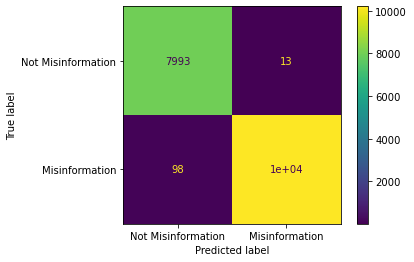

In [74]:
cmd.plot();

In [75]:
roc_auc_score(y_test, y_pred)

0.99443451947322

In [76]:
results_df = pd.DataFrame(y_test)
results_df['tweet_text'] = X_test
y_pred_proba = bestofgrid2.predict_proba(X_test)
y_pred_proba = pd.DataFrame(data = y_pred_proba, columns = ['pred0','pred1'])
results_df.insert(loc = 2, column = 'pred0' , value = y_pred_proba['pred0'].values)
results_df.insert(loc = 3, column = 'pred1' , value = y_pred_proba['pred1'].values)
results_df.insert(loc = 4, column = 'pred' , value = y_pred)

In [77]:
results_df

,target,tweet_text,pred0,pred1,pred
tweet_id,,,,,
789335093949050880.0,0,US-Wahl kompakt: Trump wird bei Benefiz-Dinner...,0.99799999999999999822,0.00200000000000000004,0
789331811981664256.0,0,RT @ObamaMalik: Trump family loves all people ...,1.00000000000000000000,0.00000000000000000000,0
1329829814249922560.0,1,@Timodc @BillKristol @Nate_Cohn @RVAT2020 I’m ...,0.00000000000000000000,1.00000000000000000000,1
789286228856274944.0,0,How Trump Will Create More ‘Bad Hombres’: The ...,0.99599999999999999645,0.00400000000000000008,0
1324622713193865216.0,1,"While evidence of VOTER FRAUD is coming in, th...",0.00000000000000000000,1.00000000000000000000,1
...,...,...,...,...,...
789263931260882944.0,0,RT @sageboggs: I miss the window in this elect...,1.00000000000000000000,0.00000000000000000000,0
789407616946479104.0,0,"RT @QuentinKidd: Women, NOVA, coll educ whites...",1.00000000000000000000,0.00000000000000000000,0
1325414016324259840.0,1,That Time When Joe Biden Bragged About Voter F...,0.00000000000000000000,1.00000000000000000000,1


In [78]:
errors_df = results_df[results_df['target'] != results_df['pred']]  

In [79]:
errors_df

,target,tweet_text,pred0,pred1,pred
tweet_id,,,,,
1329464227724210176.0,1,#Truth https://t.co/SZgFbPbjW2,0.78200000000000002842,0.21799999999999999933,0
1332402029571026944.0,1,@TherapyWestside @KamalaHarris @Official_tyler...,0.54400000000000003908,0.45600000000000001643,0
1330612952064520192.0,1,Why would they cover the windows???? No corrup...,0.92200000000000004174,0.07799999999999999989,0
1325049239353712640.0,1,😅😂😅😂😅😂😅😂😅 https://t.co/tf0Nw2N8FY,0.92000000000000003997,0.08000000000000000167,0
1325831415200669696.0,1,"Right on, my brother. We were warned way in ad...",0.96199999999999996625,0.03799999999999999906,0
...,...,...,...,...,...
1324143228363415552.0,1,Here's an interesting take. Didn't think about...,0.95999999999999996447,0.04000000000000000083,0
1329541189478064128.0,1,There should be an independent forensic ballot...,0.51800000000000001599,0.48199999999999998401,0
1324601076352385024.0,1,.@realDonaldTrump @FLOTUS @VP @EricTrump @Ivan...,0.90800000000000002931,0.09199999999999999845,0


In [70]:
false_neg_df = errors_df[errors_df['target'] == 1]
false_neg_df.sort_values(by = 'pred1', inplace = True)

false_neg_df

<ipython-input-70-524cf3dd28e8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_neg_df.sort_values(by = 'pred1', inplace = True)


,target,tweet_text,pred0,pred1,pred
tweet_id,,,,,
1329760854515052544.0,1,Fox News Calls Giuliani Liar After Conference ...,0.99799999999999999822,0.00200000000000000004,0
1322926947052277760.0,1,How is this not a conflict of interest? Trump...,0.99799999999999999822,0.00200000000000000004,0
1330316158885646336.0,1,Thats a fact. So much money and property at st...,0.99399999999999999467,0.00600000000000000012,0
1324543469801492480.0,1,Brazen!!! No shame!!!! @DonaldJTrumpJr @realDo...,0.97999999999999998224,0.02000000000000000042,0
1326411178545991680.0,1,"Lessons from WW2 were learned by this ""journal...",0.97599999999999997868,0.02400000000000000050,0
...,...,...,...,...,...
1329541189478064128.0,1,There should be an independent forensic ballot...,0.51800000000000001599,0.48199999999999998401,0
1329318761896226816.0,1,@Kiwicambo @bropologist @JackPosobiec @BobSpin...,0.50600000000000000533,0.49399999999999999467,0
1332900405014122496.0,1,@JakeCorman how can you sleep at night knowing...,0.50400000000000000355,0.49599999999999999645,0


In [80]:
most_confident_false_neg = false_neg_df.iloc[0:6].tweet_text.values

most_confident_false_neg

array(['Fox News Calls Giuliani Liar After Conference https://t.co/GxXUt06JDX',
       'How is this not a conflict of interest?  Trump should insist on a new design, and make these all obsolete. https://t.co/vu44yK3bCr',
       'Thats a fact. So much money and property at steak here.. Trump broke their bank.lmao https://t.co/afjBIDkplL',
       'Brazen!!! No shame!!!! @DonaldJTrumpJr @realDonaldTrump https://t.co/dnDEDZfCKw',
       'Lessons from WW2 were learned by this "journalist" - unfortunately from the Nazi side. CNN and WaPo = Propaganda. https://t.co/lYSzU5aXzF',
       'Ok there it is...  turn it in. https://t.co/zaGyhcBj11'],
      dtype=object)

In [81]:
false_pos_df = errors_df[errors_df['target'] == 0]
false_pos_df.sort_values(by = 'pred0', inplace = True)

false_pos_df

<ipython-input-81-a9e78aeda2be>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_pos_df.sort_values(by = 'pred0', inplace = True)


,target,tweet_text,pred0,pred1,pred
tweet_id,,,,,
789254122188906496.0,0,RT @Bakari_Sellers: But but voter fraud... htt...,0.01000000000000000021,0.98999999999999999112,1
789305130361421824.0,0,Embattled sheriff trails in reelection bid.If ...,0.14399999999999998912,0.85599999999999998312,1
789255736085712896.0,0,#TrumpBookReports #WhyIWrite #HouseholdClassic...,0.14599999999999999090,0.85399999999999998135,1
789411907954278400.0,0,RT @TRUNEWS: .@JamesCarville Admits Democratic...,0.24399999999999999467,0.75600000000000000533,1
789319533450268672.0,0,RT @MedianPolitics: .@seanhannity @newtgingric...,0.25000000000000000000,0.75000000000000000000,1
789384716650631168.0,0,RT @CBS4Indy: Gov. Pence at Nevada rally: ‘Vot...,0.28399999999999997469,0.71599999999999996980,1
789340219438870528.0,0,RT @jewelry487jw62: Aren't the state's that Vo...,0.28599999999999997646,0.71399999999999996803,1
789340031764799488.0,0,RT @FOX59: Governor Mike Pence at rally: ‘Vote...,0.32000000000000000666,0.68000000000000004885,1
789323962408853504.0,0,RT @RoboHoward: Proof in Court that th 2000 el...,0.34200000000000002620,0.65800000000000002931,1


In [82]:
most_confident_false_pos = false_pos_df.iloc[0:5].tweet_text.values
least_confident_false_pos = false_pos_df.iloc[-6:-1].tweet_text.values

most_confident_false_pos

array(['RT @Bakari_Sellers: But but voter fraud... https://t.co/oP9LlzNoVF',
       'Embattled sheriff trails in reelection bid.If he loses the voter fraud programmers will be executed on spot  https://t.co/I4ywuWuK1a',
       '#TrumpBookReports #WhyIWrite #HouseholdClassicFilms #PodestaEmails13 #ObamaEmails #VoterFraud #IsReal @BillKristol https://t.co/erYVSIKTn1',
       'RT @TRUNEWS: .@JamesCarville Admits Democratic #Election Fraud https://t.co/IBg20Jqnfr https://t.co/tGNmBVHAjC',
       'RT @MedianPolitics: .@seanhannity @newtgingrich ELECTION FRAUD \nhttps://t.co/kNRl0EqGyU'],
      dtype=object)

This looks great! I'm going to move this to the final notebook.